In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
pd.set_option('max_columns',26)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 读取数据
data = pd.read_csv('./data/letter_recognition.csv')
# 取出特征列的名称
feature_cols = data.iloc[:,2:].columns
target = 'letter'
# 统计各个字母出现的次数
letter_counts = data['letter'].value_counts()
letter_counts = pd.DataFrame((letter_counts.values.reshape(1,26)),columns=letter_counts.index,index=['count'])
letter_counts

,U,D,P,T,M,A,X,Y,N,Q,F,G,E,B,V,L,R,I,O,W,S,J,K,C,H,Z
count,813,805,803,796,792,789,787,786,783,783,775,773,768,766,764,761,758,755,753,752,748,747,739,736,734,734


In [3]:
# 切分训练集和测试集
train_size = int(data.shape[0]*0.6)
train_data = data.loc[0:train_size-1,:]
test_data = data.loc[train_size:,:]

# 二元逻辑回归配合拆解法实现多分类

## 二元逻辑回归模型

In [4]:
class binary_logistic:
    """
    class binary_logistic，二元逻辑回归分类器
     |  binary_logistic(d, threshold)
     |  提供了二元逻辑回归分类器的构造，训练和预测等功能. 
     |
     |  Parameters
     |  ----------
     |  d : int
     |      特征维度
     |  threshold : float, optional
     |      分类器阈值，当正类预测概率大于该阈值时，
     |      模型会将样本分类为正类，默认值threshold=0.5.
     |
     |  Attributes
     |  ----------
     |  predict : np.ndarray
     |      给定数据样本，给出预测分类
     |  object_function : float
     |      给定数据样本和标签，计算二元逻辑回归模型的优化目标值，即损失函数值
     |  gradient : np.ndarray
     |      给定数据样本和标签，计算优化目标object_function关于模型参数的梯度
     |  gradient_descent : None
     |      给定数据样本和标签，利用gradient计算出的梯度和梯度下降公式更新模型参数
     |  accuracy : float
     |      给定预测样本和正确标签，模型将根据计算测试集上的准确率
     |  train_model : None
     |      训练二元逻辑回归模型
     |
    """
    # 初始化函数
    def __init__(self,d : int,threshold=0.5) -> None:
        self.d = d + 1
        self.beta = np.random.randn(d + 1,1)
        self.threshold = threshold
    
    # 模型预测
    def predict(self,x : np.ndarray,label : bool) -> np.ndarray:
        x = np.concatenate((np.ones((x.shape[0],1)),x),axis=1)
        try:
            assert x.shape[1] == self.d
            p = np.exp(np.matmul(x,self.beta)) / (1 + np.exp(np.matmul(x,self.beta)))
            if label:
                # 返回
                return np.int32(p > self.threshold)
            else:
                # 返回概率分布
                return np.concatenate((p,1-p),axis=1)
        except AssertionError:
            raise Exception("输入特征的维度不等于模型参数个数，特征的维度为{}，而回归模型参数的维度为{}.".format(x.shape[1],self.d))
    
    # 采用负对数似然函数，计算优化目标
    def object_function(self,x : np.ndarray,y : np.ndarray) -> float:
        x = np.concatenate((np.ones((x.shape[0],1)),x),axis=1)
        return np.mean(-y*np.matmul(x,self.beta) + np.log(1 + np.exp(np.matmul(x,self.beta))))

    # 计算梯度
    def gradient(self,x : np.ndarray,y : np.ndarray) -> np.ndarray:
        p = self.predict(x,label=False)[:,0].reshape(-1,1)
        x = np.concatenate((np.ones((x.shape[0],1)),x),axis=1)
        grads = np.mean((p-y)*x,axis=0)
        return grads.reshape(-1,1)
    
    # 梯度下降更新参数
    def gradient_descent(self,x : np.ndarray,y : np.ndarray, lr=0.01) -> None:
        self.beta = self.beta - lr*self.gradient(x,y)
    
    # 模型的准确率
    def accuracy(self,x : np.ndarray,y_true : np.ndarray) -> float:
        y_pred = self.predict(x,label=True)
        return np.sum(y_true == y_pred) / y_true.shape[0]
    
    # 使用梯度下降训练模型
    def train_model(self,x : np.ndarray,y : np.ndarray,EPOCHS=300,lr=0.1) -> None:
        for epoch in range(EPOCHS):
            self.gradient_descent(x,y,lr=lr)

## OvO策略

字母间两两配对，构建$325$个二分类逻辑回归模型，然后预测时使用投票机制  
(1) 票数最多的字母作为预测结果  
(2) 若出现票数相同的，选择预测概率均值最大的作为预测结果  

In [5]:
def OvO_Strategy(train_data,test_data,threshold=0.5,EPOCHS=1000,lr=0.1):
    Letters = list(data['letter'].value_counts().index)
    Letters.sort()
    n = len(Letters)
    # 存储模型预测的标签
    pred_table_label = pd.DataFrame(np.zeros((test_data.shape[0],325)),columns=['pred_'+str(i+1) for i in range(325)],index=test_data.index)
    # 存储模型预测的概率分布
    pred_table_pdf = pd.DataFrame(data=None)
    n_pred = 0
    start = time.time()
    for i in range(n-1):
        for j in range(i+1,n):
            Li = Letters[i]
            Lj = Letters[j]
            train_index = (train_data['letter']==Li) | (train_data['letter']==Lj)
            x_train = train_data.loc[train_index,feature_cols]
            y_train = train_data.loc[train_index,target].copy().values.reshape(-1,1)
            y_train[y_train==Li] = 1
            y_train[y_train==Lj] = 0
            y_train = y_train.astype(int)
            model = binary_logistic(d=16,threshold=threshold)
            # 训练模型
            model.train_model(x_train,y_train,EPOCHS=EPOCHS,lr=lr)
            pred_table_label.iloc[:,n_pred] = model.predict(test_data[feature_cols],label=True)
            pdf = model.predict(test_data[feature_cols],label=False)
            pred_table_pdf.loc[:,'pred_'+str(n_pred+1)+'_'+Li] = pdf[:,0]
            pred_table_pdf.loc[:,'pred_'+str(n_pred+1)+'_'+Lj] = pdf[:,1]
            pred_table_label.iloc[pred_table_label.iloc[:,n_pred]==1,n_pred] = Li
            pred_table_label.iloc[pred_table_label.iloc[:,n_pred]==0,n_pred] = Lj
            n_pred = n_pred + 1
    end = time.time()
    print("训练用时：{}s".format(end-start))
    # 存储测试集的预测值
    y_pred = []
    # 转置以使用value_counts
    pred_table_label = pred_table_label.T
    start = time.time()
    for n_pred in range(test_data.shape[0]):
        # 统计各个字母取得最大值的次数
        rank = pred_table_label.iloc[:,n_pred].value_counts()
        # 筛出等于最大值的字母列表
        alternative = list(rank[rank.values == rank.values[0]].index)
        # 如果最大值唯一，则将下标作为预测值
        if len(alternative) == 1:
            y_pred.append(pred_table_label.iloc[:,n_pred].value_counts().index[0])
        # 若有多个字母的预测数量等于最大值，将具有最大概率均值的字母作为预测值
        else:
            # 计算各字符的均值
            alternative_mean = []
            for letter in alternative:
                cols = [letter in col for col in pred_table_pdf.columns]
                alternative_mean.append(np.mean(pred_table_pdf.loc[:,cols].loc[n_pred,(pred_table_pdf.loc[n_pred,cols]>threshold).values]))
            # 求均值的最大下标，并用下标对应的字符作为预测
            alternative_mean = np.array(alternative_mean)
            letter_arg = np.argmax(alternative_mean)
            y_pred.append(alternative[letter_arg])
    end = time.time()
    print("推理用时：{}s".format(end-start))
    return y_pred, pred_table_label, pred_table_pdf

In [6]:
y_pred_OvO, pred_table_label_OvO, pred_table_pdf_OvO = OvO_Strategy(train_data,test_data)
test_accuracy_OvO = np.sum(test_data['letter']==y_pred_OvO) / test_data.shape[0]
print("使用OvO策略，模型在测试集上的预测准确率为：{:.4f}".format(test_accuracy_OvO))

训练用时：68.43581414222717s
推理用时：7.369742393493652s
使用OvO策略，模型在测试集上的预测准确率为：0.7970


## OvR策略

每个字母与其它所有字母配对形成正负类，构建$26$个二分类逻辑回归模型，然后预测时使用概率分布进行判断  
(1) 选择26个正类预测中概率最大的一个作为预测结果    
(2) 若出现最大概率相同的，按照A-Z的顺序选择靠前的字母作为预测结果    

In [7]:
def OvR_Strategy(train_data,test_data,EPOCHS=1000,lr=0.1):
    Letters = list(data['letter'].value_counts().index)
    Letters.sort()
    # 存储模型预测的标签
    pred_table_pdf = pd.DataFrame(np.zeros((test_data.shape[0],26)),columns=['Pr_'+l for l in Letters],index=test_data.index)
    pred_time = 0
    train_time = 0
    for letter in Letters:
        x_train = train_data.loc[:,feature_cols]
        y_train = train_data.loc[:,target].copy().values.reshape(-1,1)
        y_train[y_train==letter] = 1
        y_train[y_train!=1] = 0
        y_train = y_train.astype(int)
        model = binary_logistic(d=16)
        start = time.time()
        model.train_model(x_train,y_train,EPOCHS=EPOCHS,lr=lr)
        end = time.time()
        train_time = train_time + (end-start)
        start = time.time()
        pdf = model.predict(test_data[feature_cols],label=False)
        end = time.time()
        pred_table_pdf.loc[:,'Pr_'+letter] = pdf[:,0]
        pred_time = pred_time + (end-start)
    start = time.time()
    argmax_index = np.argmax(pred_table_pdf.values,axis=1)
    y_pred = [Letters[i] for i in argmax_index]
    end = time.time()
    pred_time = pred_time + (end-start)
    print("训练用时：{}s".format(train_time))
    print("推理用时：{}s".format(pred_time))
    return y_pred, pred_table_pdf

In [8]:
y_pred_OvR, pred_table_pdf_OvR = OvR_Strategy(train_data,test_data)
test_accuracy_OvR = np.sum(test_data['letter']==y_pred_OvR) / test_data.shape[0]
print("使用OvR策略，模型在测试集上的预测准确率为：{:.4f}".format(test_accuracy_OvR))

训练用时：75.91919231414795s
推理用时：0.044124603271484375s
使用OvR策略，模型在测试集上的预测准确率为：0.6817


# 多元逻辑回归

## 多元逻辑回归模型

In [9]:
class multiple_logistic:
    """
    class multiple_logistic，多元逻辑回归分类器
     |  multiple_logistic(K, d)
     |  提供了多元逻辑回归分类器的构造，训练和预测等功能. 
     |
     |  Parameters
     |  ----------
     |  K : int
     |      多分类数量
     |  d : int
     |      特征维度
     |
     |  Attributes
     |  ----------
     |  predict : np.ndarray
     |      给定数据样本，给出预测分类
     |  object_function : float
     |      给定数据样本和标签，计算多元逻辑回归模型的优化目标值，即损失函数值
     |  gradient : np.ndarray
     |      给定数据样本和标签，计算优化目标object_function关于模型参数的梯度
     |  gradient_descent : None
     |      给定数据样本和标签，利用gradient计算出的梯度和梯度下降公式更新模型参数
     |  accuracy : float
     |      给定预测样本和正确标签，模型将根据计算测试集上的准确率
     |  train_model : None
     |      训练多元逻辑回归模型
     |
    """
    # 初始化函数
    def __init__(self,K : int,d : int) -> None:
        self.K = K
        self.d = d + 1
        self.beta = np.random.randn(d+1,K-1)
    
    # 模型预测
    def predict(self,x : np.ndarray,label : bool) -> np.ndarray:
        x = np.concatenate((np.ones((x.shape[0],1)),x),axis=1)
        try:
            assert x.shape[1] == self.d
            p = np.zeros((x.shape[0],self.K))
            denominator = 1 + np.exp(np.matmul(x,self.beta)).sum(axis=1)
            for i in range(self.K-1):
                p[:,i] = np.exp(np.matmul(x,self.beta[:,i])) / denominator
            p[:,-1] = 1 - p.sum(axis=1)
            argmax_index = np.argmax(p,axis=1)
            if label:
                return argmax_index.reshape(-1,1)
            else:
                return p
        except:
            raise Exception("输入特征的维度不等于模型参数个数，特征的维度为{}，而回归模型参数的维度为{}.".format(x.shape[1],self.d))
    
    # 采用负对数似然函数，计算优化目标
    def object_function(self,x : np.ndarray,y : np.ndarray) -> float:
        x = np.concatenate((np.ones((x.shape[0],1)),x),axis=1)
        denominator = 1 + np.exp(np.matmul(x,self.beta)).sum(axis=1)
        values = np.matmul(x,self.beta)
        # 示性函数的计算
        identity = np.zeros_like(values)
        identity = identity.flatten()
        identity[np.array([values.shape[1]*i+e for i,e in enumerate(y)])] = 1
        identity = identity.reshape(values.shape)
        return (np.log(denominator) - (identity*values).sum(axis=1)).mean(axis=0)

    # 计算梯度
    def gradient(self,x : np.ndarray,y : np.ndarray) -> np.ndarray:
        p = self.predict(x,label=False)
        grads = np.zeros_like(self.beta)
        # 示性函数的计算
        n = x.shape[0]
        K = self.beta.shape[1]
        identity = np.zeros((n,K))
        identity = identity.flatten()
        identity[np.array([K*i+e for i,e in enumerate(y)])] = 1
        identity = identity.reshape(n,K)
        x = np.concatenate((np.ones((x.shape[0],1)),x),axis=1)
        for k in range(K):
            grads[:,k] = ((p[:,k] - identity[:,k]).reshape(-1,1)*x).mean(axis=0)
        return grads
    
    # 梯度下降更新参数
    def gradient_descent(self,x : np.ndarray,y : np.ndarray,lr) -> None:
        self.beta = self.beta - lr*self.gradient(x,y)
    
    # 模型准确率
    def accuracy(self,x : np.ndarray,y_true : np.ndarray) -> float:
        y_pred = self.predict(x,label=True)
        return np.sum(y_true == y_pred) / y_true.shape[0]
    # 使用梯度下降训练模型
    def train_model(self,x_train : np.ndarray, y_train : np.ndarray,
                         x_test : np.ndarray, y_test : np.ndarray,
                         EPOCHS=1000,lr=0.1,verbose=0) -> None:
        if verbose == 1:
            train_acc = []
            test_acc = []
        for epoch in range(EPOCHS):
            self.gradient_descent(x_train,y_train,lr=lr)
            if (epoch+1)%10 == 0 and verbose == 1:
                train_acc.append(self.accuracy(x_train,y_train))
                test_acc.append(self.accuracy(x_test,y_test))
        if verbose == 0:
            return None
        if verbose == 1:
            return train_acc, test_acc

In [10]:
def multiple_logistic_Strategy(train_data,test_data,EPOCHS=1000,lr=0.1):
    Letters = list(data['letter'].value_counts().index)
    Letters.sort()
    Letters_dict = {}
    for i,letter in enumerate(Letters):
        Letters_dict[letter] = i
    x_train = train_data[feature_cols]
    x_test = test_data[feature_cols]
    y_train = train_data['letter']
    y_test = test_data['letter']
    y_train = [Letters_dict[i] for i in y_train]
    y_train = np.array(y_train).reshape(-1,1)
    y_test = [Letters_dict[i] for i in y_test]
    y_test = np.array(y_test).reshape(-1,1)
    model = multiple_logistic(K=26,d=16)
    start = time.time()
    train_acc, test_acc = model.train_model(x_train,y_train,x_test,y_test,EPOCHS=EPOCHS,lr=lr,verbose=1)
    end = time.time()
    print("训练用时：{}s".format(end-start))
    fig = plt.figure(figsize=(7,5),dpi=100)
    plt.plot(np.arange(0,EPOCHS,10),train_acc,label='trian acc')
    plt.plot(np.arange(0,EPOCHS,10),test_acc,label='test acc')
    plt.xlabel('epoch')
    plt.legend()
    start = time.time()
    y_pred = model.predict(x_test,label=True)
    end = time.time()
    print("推理用时：{}s".format(end-start))
    accuracy = model.accuracy(x_test,y_true=y_test)
    return y_pred, accuracy

训练用时：89.2707188129425s
推理用时：0.010970830917358398s
使用多元逻辑策略，模型在测试集上的预测准确率为：0.6585


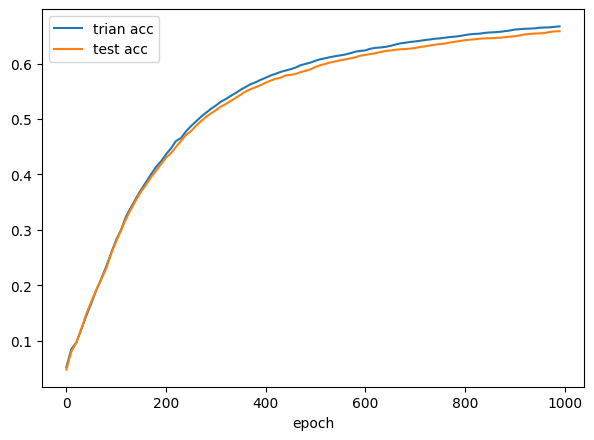

In [11]:
y_pred_mul, test_accuracy_mul = multiple_logistic_Strategy(train_data,test_data,EPOCHS=1000)
print("使用多元逻辑策略，模型在测试集上的预测准确率为：{:.4f}".format(test_accuracy_mul))